# Import modules

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import sys
sys.path.append('../')
from src.config import *
from src.helper_visualization import *
from src.helper_pred import *
from src.helper_pipeline import *

# Configuration

In [29]:
# CONGRATULATIONS, ready to go 🚀

# DATA PREPARATION
TITLE_WORDS_MIN = 4             # the minimum number of words in the title
TITLE_WORDS_MAX = 15            # the maximum number of words in the title
TEXT_COL = 'Title_Translated'   # the text column to be used for training
TARGET_COL = 'Product Name'     # the target column to be used for training
FILER_COL = 'Length'            # the filter column to be used for training
MAX_FEATURES = 20000            # the maximum number of features for vectorizer
PRODUCT_SIZE_MAX_TRAIN = 4000   # the maximum number of samples for each product in training set to balance the data
PRODUCT_SIZE_MAX_TEST = None    # the maximum number of samples for each product in test set to balance the data
TOP_N_PRODUCTS = 25             # the top n products to be used for training, the rest will be lumped into 'Others'
PRODUCT_OTHERS = f'Other Products (not in Top {TOP_N_PRODUCTS})' # the name of the 'Others' product
# TRAINING
CLASS_WEIGHT_FACTOR = 3         # the times of the largest class as the weight of the minor classes. set to 1 to disable class weight

# CONGRATULATIONS, ready to go 🚀

# Load Data

In [ ]:
if 'df_train' not in locals():
    excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
    df_train = pd.read_excel(excel_file_train)
    excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
    df_test = pd.read_excel(excel_file_test)

hist_by_labels(df_train, 'Length', log=False, left=TITLE_WORDS_MIN-.5, right=TITLE_WORDS_MAX+.5)
hist_by_labels(df_train, 'Product Name', log=True, right=TOP_N_PRODUCTS-.5)

# Get the Product Name list of Top N products
def get_top_n_products(df, target_col, n):
    df_target = df[target_col].value_counts().to_frame().reset_index()
    df_target.columns = [target_col, 'count']
    df_target = df_target.sort_values(by='count', ascending=False)
    df_target = df_target.head(n)
    return df_target[target_col].tolist()

top_n_products = get_top_n_products(df_train, TARGET_COL, TOP_N_PRODUCTS)

# Train/Test Datasets

Pipeline Construction

In [3]:
# # create a scikit-learn pipeline to remove the title with less than 3 words or more than 20 words
pipleline_data_prep_train = Pipeline([
    ('title_length_filter', TitleLengthFilter(filter_name=FILER_COL, min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('other_products_combiner', OtherProductsCombiner(top_products=top_n_products, target_col=TARGET_COL, product_name=PRODUCT_OTHERS)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TRAIN, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])

pipleline_data_prep_test = Pipeline([
    ('title_length_filter', TitleLengthFilter(filter_name=FILER_COL, min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('other_products_combiner', OtherProductsCombiner(top_products=top_n_products, target_col=TARGET_COL, product_name=PRODUCT_OTHERS)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TEST, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])

display(pipeline_data_prep_train)
display(pipeline_data_prep_test)

Pipeline(steps=[('title_length_filter',
                 TitleLengthFilter(max_words=15, min_words=4)),
                ('other_products_combiner',
                 OtherProductsCombiner(target_col='Product Name',
                                       top_products=['Petrel',
                                                     'RE (Petrel RE, DELFI RE, '
                                                     'ECLIPSE, INTERSECT, '
                                                     'ODRS, FluidModeler)',
                                                     'Delfi Portal', 'Techlog',
                                                     'RTDS',
                                                     'ProdOps, Avocet, PDF',
                                                     'OFM', 'PIPESIM, IAM',
                                                     'Deployment', 'OLGA',
                                                     'DrillPlan', 'Studio',
                                                     'Edge', 'RigHour',
                                                     'Storage, File '
                                                     'Management, Secure Data '
                                                     'Exchange',
                                                     'MERAK',
                                                     'Omega, VISTA, OMNI3D',
                                                     'Symmetry',
                                                     'ProSource, InnerLogix',
                                                     'PetroMod', 'DrillOps',
                                                     'GeoX', 'InterACT Inside',
                                                     '3rd Party',
                                                     'Data Science'])),
                ('sample_capper',
                 SampleCapper(max_samples=4000, target_col='Product Name')),
                ('text_lower', TextLower(text_col='Title_Translated'))])

Pipeline(steps=[('title_length_filter',
                 TitleLengthFilter(max_words=15, min_words=4)),
                ('other_products_combiner',
                 OtherProductsCombiner(target_col='Product Name',
                                       top_products=['Petrel',
                                                     'RE (Petrel RE, DELFI RE, '
                                                     'ECLIPSE, INTERSECT, '
                                                     'ODRS, FluidModeler)',
                                                     'Delfi Portal', 'Techlog',
                                                     'RTDS',
                                                     'ProdOps, Avocet, PDF',
                                                     'OFM', 'PIPESIM, IAM',
                                                     'Deployment', 'OLGA',
                                                     'DrillPlan', 'Studio',
                                                     'Edge', 'RigHour',
                                                     'Storage, File '
                                                     'Management, Secure Data '
                                                     'Exchange',
                                                     'MERAK',
                                                     'Omega, VISTA, OMNI3D',
                                                     'Symmetry',
                                                     'ProSource, InnerLogix',
                                                     'PetroMod', 'DrillOps',
                                                     'GeoX', 'InterACT Inside',
                                                     '3rd Party',
                                                     'Data Science'])),
                ('sample_capper', SampleCapper(target_col='Product Name')),
                ('text_lower', TextLower(text_col='Title_Translated'))])

Data Processing

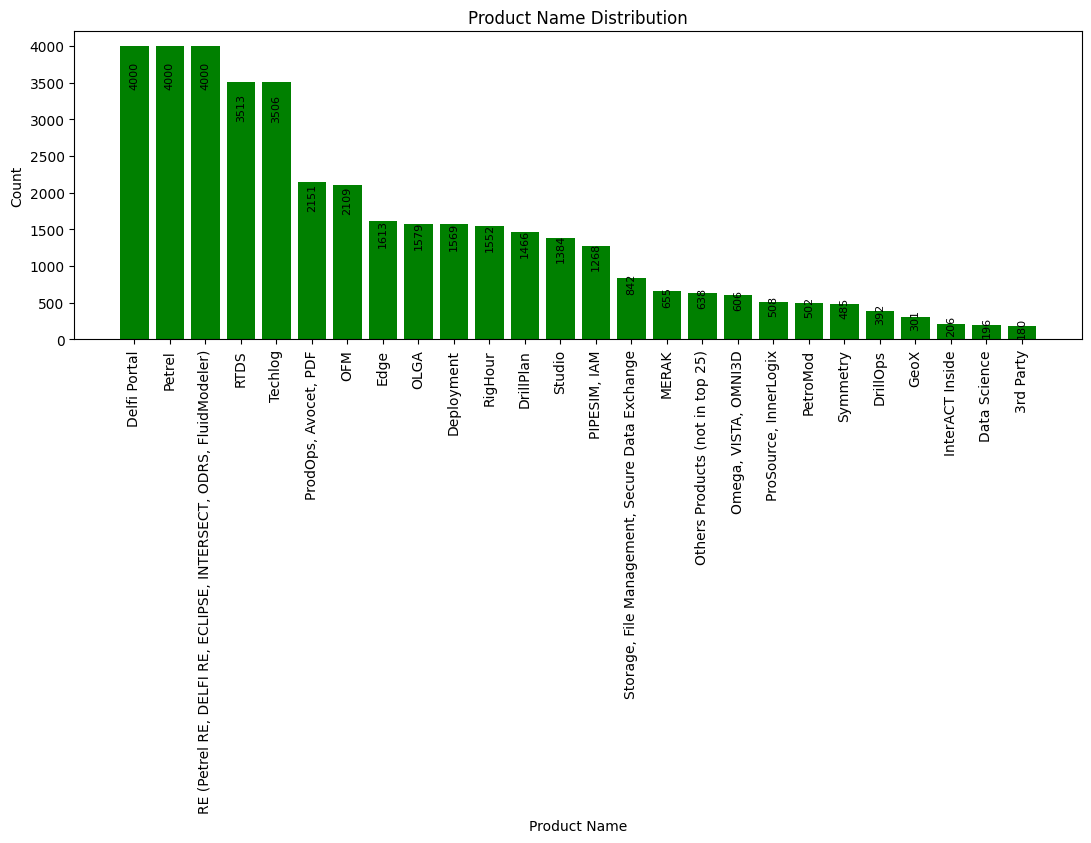

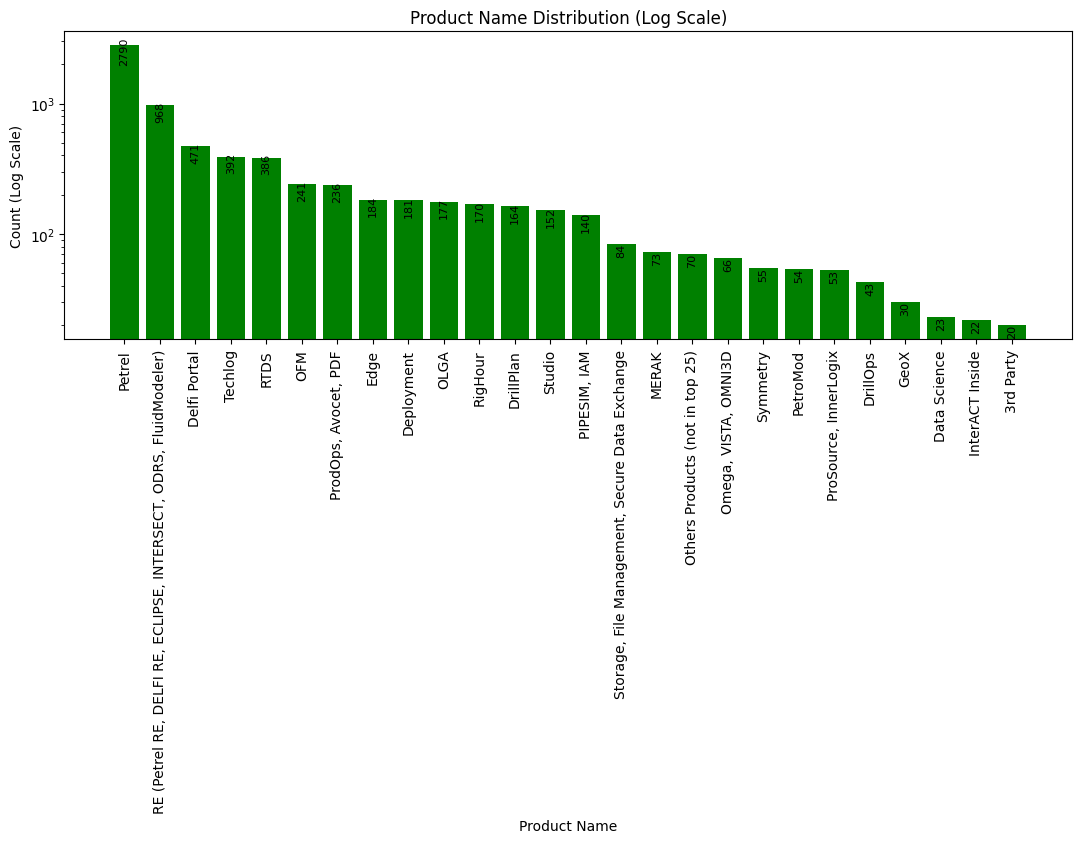

In [4]:
train_data = pipeline_data_prep_train.fit_transform(df_train)
test_data = pipeline_data_prep_test.fit_transform(df_test)
hist_by_labels(train_data, TARGET_COL, log=False, horizontal=True)
hist_by_labels(test_data, TARGET_COL, log=True, horizontal=True)

# Model Baseline - Cross Validation

In [5]:
# SciKit-Learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Optuna
import optuna
import optuna.visualization as vis

# Others
import pickle

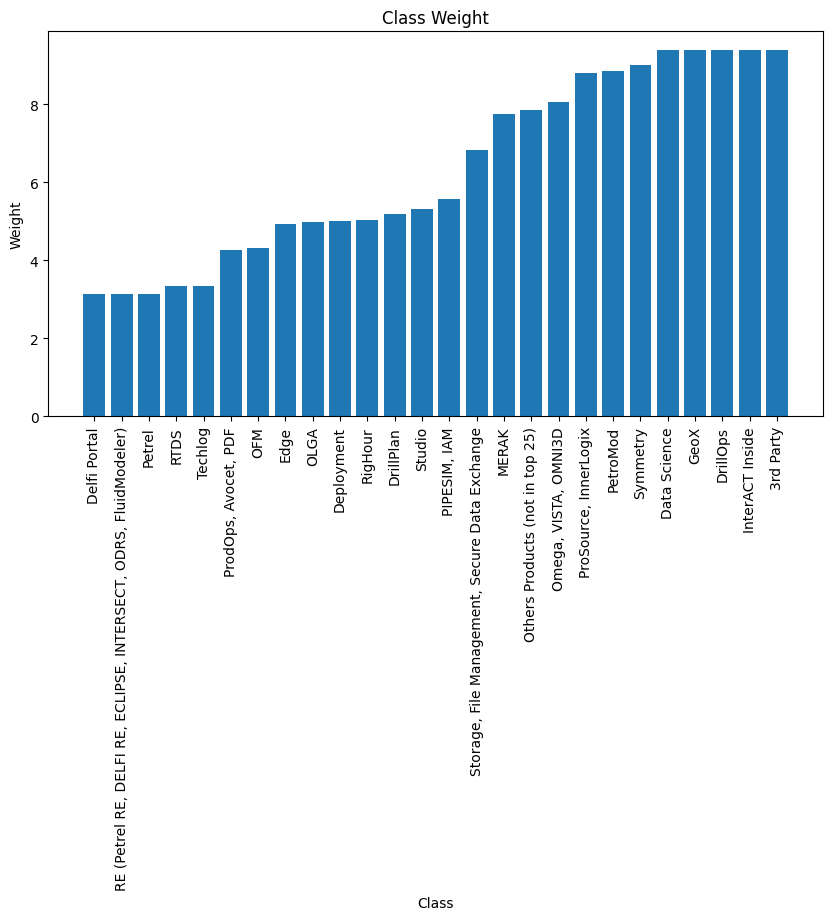

In [6]:
# create vectorizer for text
vectorizer_countvec = CountVectorizer(max_features=MAX_FEATURES, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf = TfidfVectorizer(max_features=MAX_FEATURES, analyzer='word', ngram_range=(1, 2))

X = df_train[TEXT_COL]
vectorizer_countvec.fit(X)
vectorizer_tfidf.fit(X)

vectorizer = vectorizer_tfidf

X_train = train_data[TEXT_COL]
y_train = train_data[TARGET_COL]
X_train_encoded = vectorizer.transform(X_train)

X_test = test_data[TEXT_COL]
X_test_encoded = vectorizer.transform(X_test)
y_test = test_data[TARGET_COL]

# calculate the class weight of X_train
class_weight = dict()
for label in y_train.unique():
    class_weight[label] = len(y_train)/len(y_train[y_train==label])

class_weight_max = np.sqrt(min(class_weight.values()))*CLASS_WEIGHT_FACTOR
# apply sqrt() to the class weight
for label in class_weight.keys():
    class_weight[label] = min(class_weight_max, np.sqrt(class_weight[label]))
plot_class_weights(class_weight)

In [ ]:
# create a dictionary of models
models = {
    'SGDClassifier': SGDClassifier(max_iter=5000, class_weight=class_weight ),
    'LogisticRegression': LogisticRegression(max_iter=5000, class_weight=class_weight),
    'SVC linear': SVC(kernel='linear', class_weight=class_weight),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'MultinomialNB': MultinomialNB(class_weight=class_weight)
    # 'SVC rbf': SVC(kernel='rbf'),
}

print(f'Configuration: Classify top \033[94m{TOP_N_PRODUCTS}\033[0m products; Text column: \033[94m{TEXT_COL}\033[0m, Title words length: (\033[94m{TITLE_WORDS_MIN}\033[0m, \033[94m{TITLE_WORDS_MAX}\033[0m); Records/product caped at \033[94m{PRODUCT_SIZE_MAX_TRAIN}\033[0m')
print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        X_train_encoded,
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

In [ ]:
# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15); Records/product caped at 4000
# Baseline Score(s) of each model are ....
# Average score: 0.8279 by SGDClassifier.
# Average score: 0.8217 by LogisticRegression.
# Average score: 0.8070 by SVC linear.

# Configuration: TITLE_WORDS_MIN=4, TITLE_WORDS_MAX=15, TEXT_COL=Title_Translated, PRODUCT_SIZE_MAX_TRAIN=2000, TOP_N_PRODUCTS=25.
# Baseline Score(s) of each model are ....
# Average score: 0.8245 by SGDClassifier.
# Average score: 0.8193 by LogisticRegression.
# Average score: 0.8038 by SVC linear.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=4, TITLE_WORDS_MAX = 15 Title_Translated, with class_weight, 
# Average score: 0.8242 by SGDClassifier.
# Average score: 0.8193 by LogisticRegression.
# Average score: 0.8038 by SVC linear.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=4, TITLE_WORDS_MAX = 15 Title_Translated
# Average score: 0.8206 by SGDClassifier.
# Average score: 0.8121 by SVC linear.
# Average score: 0.8018 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=4, TITLE_WORDS_MAX = 15 Title_Translated
# Average score: 0.8196 by SGDClassifier.
# Average score: 0.8108 by SVC linear.
# Average score: 0.7994 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=3, TITLE_WORDS_MAX = 15 Title_Translated
# Average score: 0.8091 by SGDClassifier.
# Average score: 0.8030 by SVC linear.
# Average score: 0.7921 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=4, TITLE_WORDS_MAX = 15 Title_Enhanced
# Baseline Score(s) of each model are .... 3000 samples per product max
# Average score: 0.8144 by SGDClassifier.
# Average score: 0.8134 by SVC linear.
# Average score: 0.8013 by LogisticRegression.

# Average score: 0.8150 by SGDClassifier.  2000 samples per product max
# Average score: 0.8098 by SVC linear.
# Average score: 0.7996 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=3, TITLE_WORDS_MAX = 15 Title_Enhanced
# Average score: 0.8050 by SGDClassifier.
# Average score: 0.8021 by SVC linear.
# Average score: 0.7909 by LogisticRegression.

# Hpyerparameter Tuning

## SGC Classifier (5min/100trials)

In [ ]:
# Clean up the study if it exists
study_name = 'sgd_classifier'
storage_name = 'sqlite:///optuna_study.db'

try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-7, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']), #'hinge and square_hinge doesn't work with model.predict_proba() and is very slow
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(class_weight=class_weight, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_encoded, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(class_weight=class_weight, **best_params)
best_model_sgc.fit(X_train_encoded, y_train)

# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred_sgc)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m on test data size \033[94m{len(y_test)}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15); Records/product caped at 4000
# Accuracy of top 1 prediction is 0.822.
# Accuracy of top 3 prediction is 0.946.
# Accuracy of top 5 prediction is 0.968.
# export the model
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))

In [ ]:
# CONGRATULATIONS, ready to go 🚀
# ref: https://huggingface.co/transformers/v3.3.1/pretrained_models.html
# BERT_MODEL = 'bert-base-uncased' # 12-layer, 768-hidden, 12-heads, 110M parameters. Trained on lower-cased English text.
BERT_MODEL = 'distilbert-base-uncased' # 6-layer, 768-hidden, 12-heads, 66M parameters. Trained on lower-cased English text.
MAX_EPOCH = 50
EARLY_STOP_PATIENCE = 5
BATCH_SIZE = 128
FRACTION = 1
# CONGRATULATIONS, ready to go 🚀

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
def tokenize(batch):
    return tokenizer(batch['text'], 
                    max_length=TITLE_WORDS_MAX,
                    padding='max_length', 
                    truncation=True)

# Split train data into train and eval
train_data = df_train_processed[['text', 'label']]
train_data, eval_data = train_test_split(train_data, test_size=0.15, stratify=train_data['label'], random_state=42)

# Sample the train and eval data to speed up the training
train_data = train_data.sample(frac=FRACTION, random_state=42).reset_index(drop=True)
eval_data = eval_data.sample(frac=FRACTION, random_state=42).reset_index(drop=True)

# Get the number of classes
n_classes = len(train_data.label.unique())

# Class weighting
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=train_data.label.unique(), y=train_data.label)
class_weight_max = np.sqrt(class_weights.min())*3
class_weights = {i: min(np.sqrt(class_weights[i]), class_weight_max) for i in range(len(class_weights))}
plot_class_weights(class_weights)

hg_train_data = Dataset.from_pandas(train_data)
hg_eval_data = Dataset.from_pandas(eval_data)

# Tokenize the train and eval data
hg_train_data_tokenized = hg_train_data.map(tokenize)
hg_eval_data_tokenized = hg_eval_data.map(tokenize)

## Logistic Classification (10min/10trials)

In [7]:
# Clean up the study if it exists
study_name = 'logReg'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

In [12]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']), #sag and 'saga' are is slow to converge
        'C': trial.suggest_float('C', 1e-2, 1e+2, log=True),
        'penalty': 'l2',
        'multi_class': 'ovr',
        'max_iter': 50000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(class_weight=class_weight, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-31 12:13:29,033] Using an existing study with name 'logReg' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-10-31 12:17:29,314] Trial 15 finished with value: 0.823920929118447 and parameters: {'solver': 'lbfgs', 'C': 1.883338053705767}. Best is trial 7 with value: 0.8246348440868445.
[I 2023-10-31 12:19:26,947] Trial 10 finished with value: 0.8251192810473448 and parameters: {'solver': 'lbfgs', 'C': 1.135916494850154}. Best is trial 10 with value: 0.8251192810473448.
[I 2023-10-31 12:19:36,931] Trial 16 finished with value: 0.8251192745471038 and parameters: {'solver': 'lbfgs', 'C': 1.343331281240198}. Best is trial 10 with value: 0.8251192810473448.
[I 2023-10-31 12:19:47,193] Trial 12 finished with value: 0.8249153067349972 and parameters: {'solver': 'lbfgs', 'C': 1.6608457267970917}. Best is trial 10 with value: 0.8251192810473448.
[I 2023-10-31 12:19:48,203] Trial 13 finished with value: 0.8247878207584545 and parameters: {'solver': 'lbfgs', 'C': 1.6314497014966753}. Best is trial 10 with value: 0.8251192810473448.
[I 2023-10-31 12:19:55,889] Trial 17 finished with value: 0.82488

In [13]:
vis.plot_optimization_history(study)

In [14]:
vis.plot_slice(study)

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy: 0.8108
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.316     0.300     0.308        20
                                                    Data Science      0.619     0.565     0.591        23
                                                    Delfi Portal      0.580     0.735     0.648       471
                                                      Deployment      0.658     0.669     0.663       181
                                                        DrillOps      0.842     0.744     0.790        43
                                                       DrillPlan      0.681     0.848     0.755       164
                                                            Edge      0.978     0.989     0.984       184
                                                            GeoX      0.862     0.833     0.847        30
                            

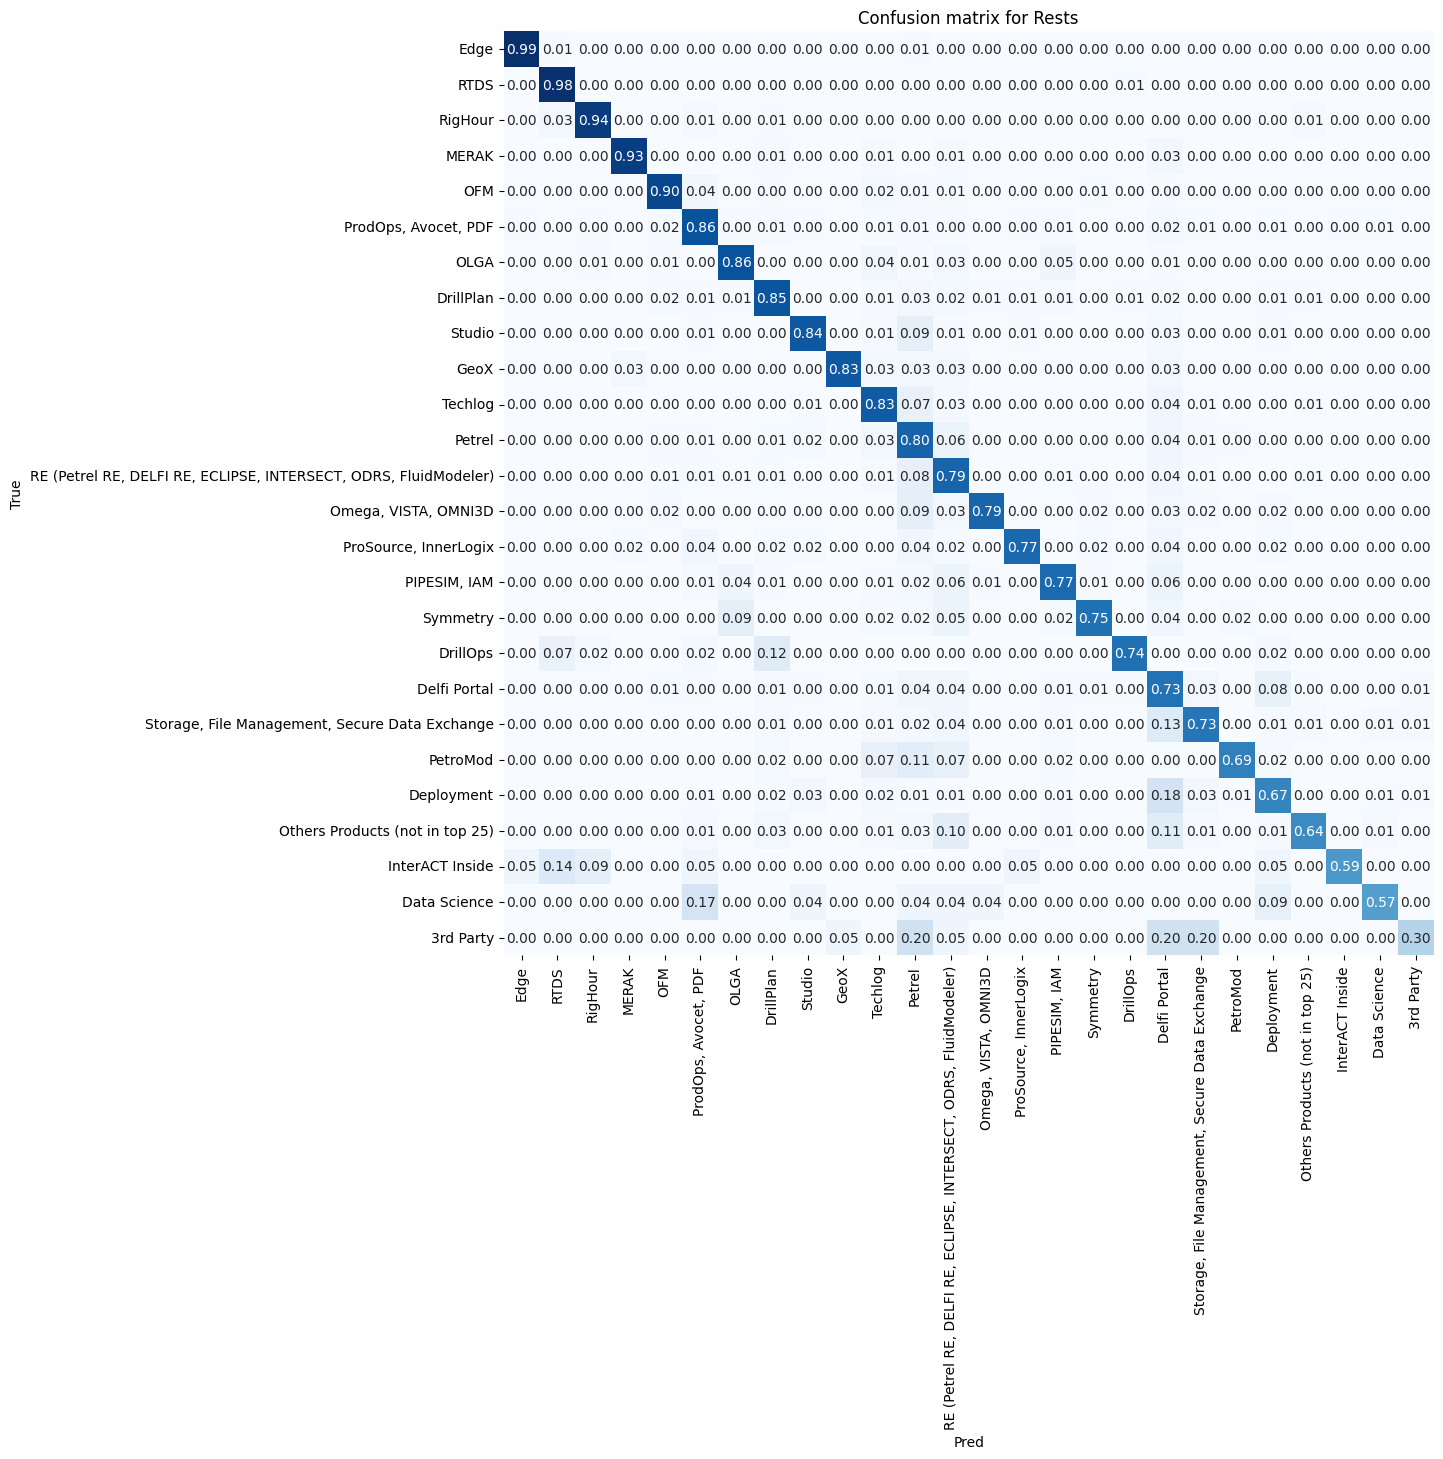

Accuracy of top 1 prediction is 0.811.
Accuracy of top 3 prediction is 0.947.
Accuracy of top 5 prediction is 0.971.


In [15]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(class_weight=class_weight, **best_params)
best_model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [16]:
# Configuration: Classify top 25 products; Text column: Title_Translated, Title words length: (4, 15); Records/product caped at 4000
# Accuracy of top 1 prediction is 0.812.
# Accuracy of top 3 prediction is 0.948.
# Accuracy of top 5 prediction is 0.972.
# export the model
pickle.dump(best_model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB (2min)

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=250, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# Accuracy of top 1 prediction is 0.789.
# Accuracy of top 3 prediction is 0.927.
# Accuracy of top 5 prediction is 0.956.
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer_countvec, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear (>60min)

In [27]:
# user Optuna to tune the hyperparameters for SVC Linear
study_name = 'SVC_linear'
storage_name = 'sqlite:///optuna_study.db'

# Clean up the study if it exists
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [28]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1e-2, 1e+2, log=True),
        'max_iter': 50000,
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', probability=True, class_weight=class_weight, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(
    objective,
    n_trials=20, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)

[I 2023-10-31 14:06:53,890] A new study created in RDB with name: SVC_linear


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-31 14:38:40,933] Trial 8 finished with value: 0.8045944743401361 and parameters: {'C': 1.280001997492467}. Best is trial 8 with value: 0.8045944743401361.
[I 2023-10-31 14:41:40,900] Trial 9 finished with value: 0.8031666834047873 and parameters: {'C': 1.4751752754413106}. Best is trial 8 with value: 0.8045944743401361.
[I 2023-10-31 14:41:42,118] Trial 1 finished with value: 0.8007444953521652 and parameters: {'C': 1.8997581398179033}. Best is trial 8 with value: 0.8045944743401361.
[I 2023-10-31 14:41:42,617] Trial 7 finished with value: 0.8009229724692043 and parameters: {'C': 1.8367948915534595}. Best is trial 8 with value: 0.8045944743401361.
[I 2023-10-31 14:41:43,362] Trial 4 finished with value: 0.8019428407808219 and parameters: {'C': 1.6192142681929966}. Best is trial 8 with value: 0.8045944743401361.
[I 2023-10-31 14:41:43,748] Trial 0 finished with value: 0.8016113707415702 and parameters: {'C': 1.7509428335653188}. Best is trial 8 with value: 0.8045944743401361.

In [30]:
vis.plot_optimization_history(study)

In [31]:
vis.plot_slice(study)

In [32]:
# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', probability=True, class_weight=class_weight, **best_params)
best_model_svc_linear.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# Accuracy of top 1 prediction is 0.816.
# Accuracy of top 3 prediction is 0.935.
# Accuracy of top 5 prediction is 0.964.
pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_svc_linear.pkl', 'wb'))

## RandomForestClassifier

In [ ]:
# user Optuna to tune the hyperparameters for RandomForestClassifier

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 4000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_random_forest = RandomForestClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_random_forest, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)

best_model_random_forest = RandomForestClassifier(**best_params)
best_model_random_forest.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_random_forest = best_model_random_forest.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_random_forest, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_random_forest, title='Confusion matrix for Rests')
df_pred_top5_random_forest = top5_accuracy_report(best_model_random_forest, vectorizer_tfidf, X_test, y_test, pre_processed=True)

pickle.dump(best_model_random_forest, open(f'{MODEL_FOLDER_PATH}/model_random_forest.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_random_forest.pkl', 'wb'))

## Voting model

In [ ]:
# now we have three models, logistic regression, multinomialNB and svc_linear, we can use voting classifier to combine them together
from sklearn.ensemble import VotingClassifier

# Create a dictionary of the models
estimators = [
    ('logReg', best_model_logReg),
    ('svc_linear', best_model_svc_linear),
    ('sgc_classifier', best_model_sgc),
]

# Create a voting classifier
voting = VotingClassifier(estimators, voting='soft', n_jobs=-1)

# Fit the voting classifier to the training data
voting.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_voting = voting.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_voting, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_voting, title='Confusion matrix for Rests')

df_pred_top5_voting = top5_accuracy_report(voting, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# Accuracy of top 1 prediction is 0.824.
# Accuracy of top 3 prediction is 0.936.
# Accuracy of top 5 prediction is 0.963.
pickle.dump(voting, open(f'{MODEL_FOLDER_PATH}/model_voting.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_voting.pkl', 'wb'))